# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.096557,True,5.134490
1,0.910054,False,1.737545
2,-0.114418,False,-0.044407
3,2.299936,True,8.618177
4,0.458496,True,4.136676
...,...,...,...
995,-0.000868,True,5.213156
996,0.072987,False,0.945850
997,1.376550,True,8.180010
998,0.227290,True,6.886411


<AxesSubplot: xlabel='v0'>

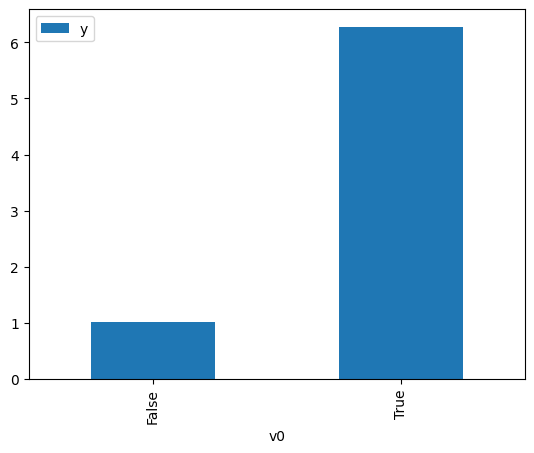

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

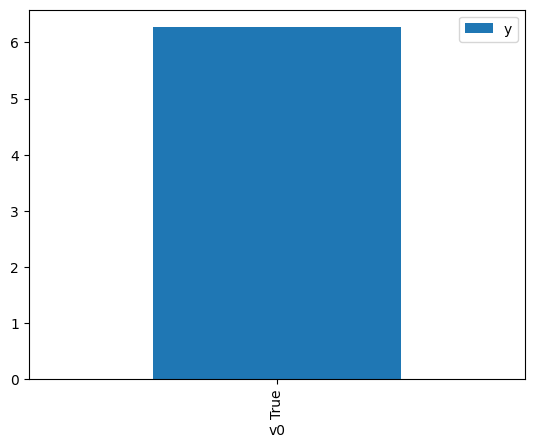

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.497564,False,-1.460581,0.609061,1.641871
1,-0.620101,False,-0.379875,0.639080,1.564748
2,0.861394,False,1.938675,0.273635,3.654506
3,0.384774,False,-0.493140,0.382639,2.613427
4,0.533555,False,0.872557,0.346653,2.884729
...,...,...,...,...,...
995,2.062752,False,4.580059,0.096979,10.311497
996,0.909462,False,3.419034,0.263769,3.791202
997,2.734418,False,7.680332,0.050551,19.782036
998,0.959045,False,0.596653,0.253834,3.939589


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.569883,True,5.904845,0.661891,1.510822
1,1.193764,True,8.371878,0.789758,1.266211
2,1.820781,True,6.861884,0.878519,1.138280
3,0.159546,True,6.003763,0.560472,1.784210
4,-0.206398,True,5.643312,0.465255,2.149358
...,...,...,...,...,...
995,0.206462,True,6.540224,0.572507,1.746703
996,2.392158,True,10.554120,0.929259,1.076126
997,1.140164,True,7.527263,0.780310,1.281542
998,-1.048455,True,2.421080,0.265251,3.770014


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.970
Method:                 Least Squares   F-statistic:                          1.644e+04
Date:                Tue, 22 Nov 2022   Prob (F-statistic):                        0.00
Time:                        18:13:54   Log-Likelihood:                         -1419.4
No. Observations:                1000   AIC:                                      2843.
Df Residuals:                     998   BIC:                                      2853.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8770      0.035     53.470      0.000       1.808       1.946
x2             5.0406      0.051     98.230      0.000       4.940       5.141
==============================================================================
Omnibus:                        0.137   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.934   Jarque-Bera (JB):                0.107
Skew:                           0.025   Prob(JB):                        0.948
Kurtosis:                       3.010   Cond. No.                         2.38
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""